In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_data = pd.read_csv('/content/drive/My Drive/Heart Arrhythmia/mitbih_train.csv',header=None)
test_data= pd.read_csv('/content/drive/My Drive/Heart Arrhythmia/mitbih_test.csv',header=None)

In [0]:
X_train = pd.read_csv('/content/drive/My Drive/Heart Arrhythmia/mitbih_train.csv',header=None,usecols=range(187))
Y_train = pd.read_csv('/content/drive/My Drive/Heart Arrhythmia/mitbih_train.csv',header=None,usecols=[187]).iloc[:,0]

In [29]:
train_data.shape

(87554, 188)

In [30]:
test_data.shape

(21892, 188)

In [31]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:

raw = pd.concat([train_data,test_data], axis=0)

In [49]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [51]:
raw[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

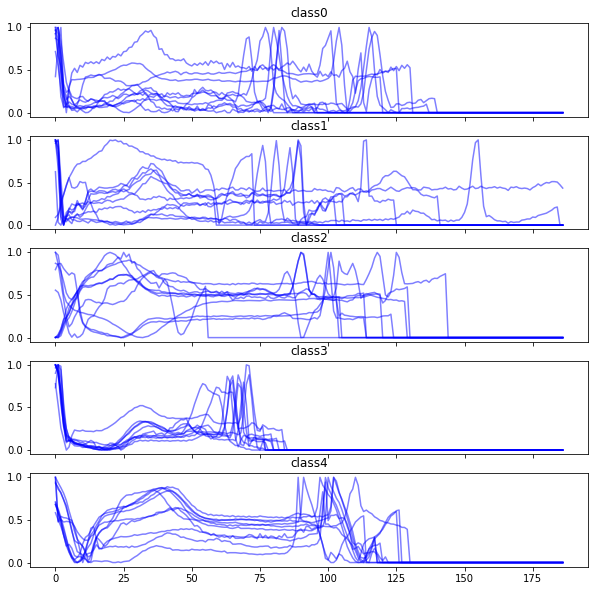

In [24]:
def plot(x_data, y_data, classes=range(5), plots_per_class=10):

    f, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(10,10))
    for i in classes:
        for j in range(plots_per_class):
            ax[i].set_title("class{}".format(i))
            ax[i].plot(x_data[y_data == i].iloc[j,:], color="blue", alpha=.5)
            
plot(X_train,Y_train)

In [0]:
M = raw.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [0]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()


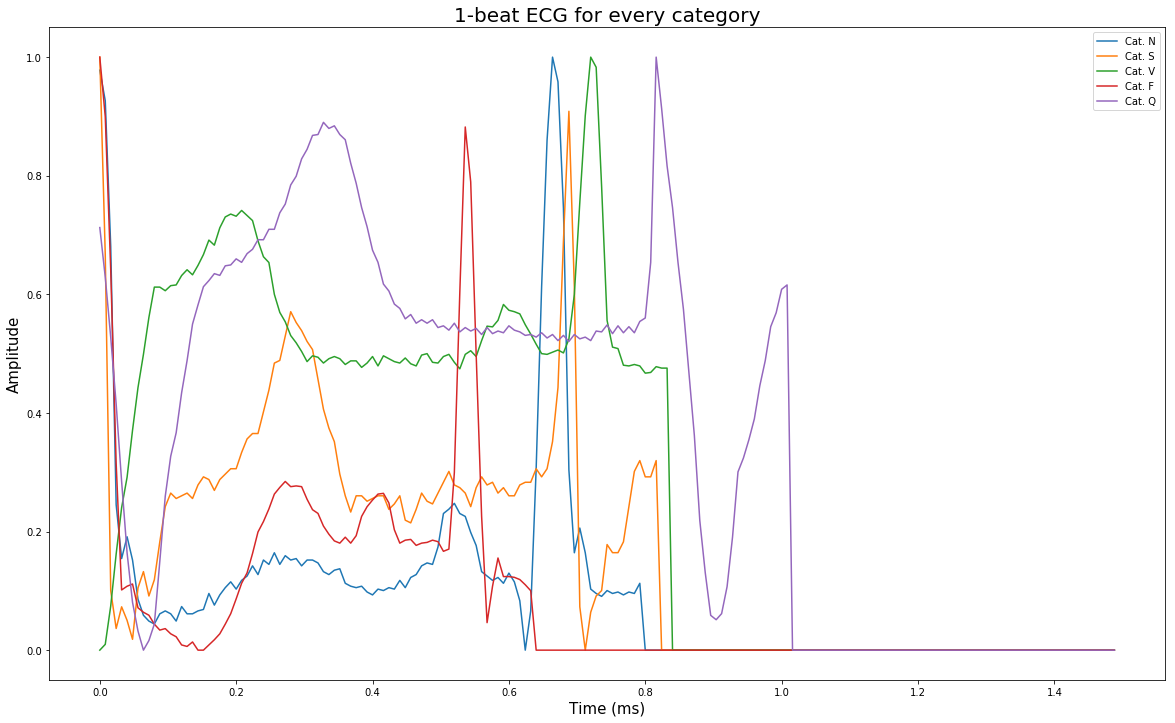

In [17]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

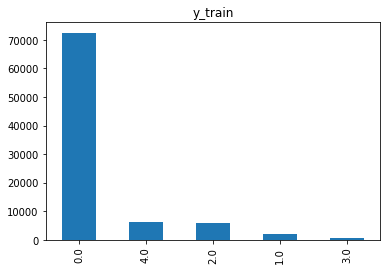

In [32]:
train_data[187].value_counts().plot(kind="bar", title="Train Data")

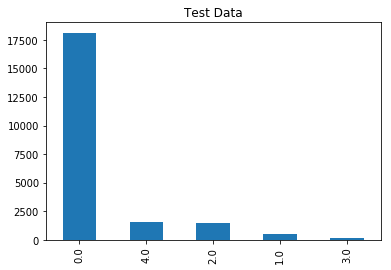

In [33]:
test_data[187].value_counts().plot(kind="bar", title="Test Data")

In [0]:
from scipy.signal import gaussian, decimate
from scipy.sparse import csr_matrix

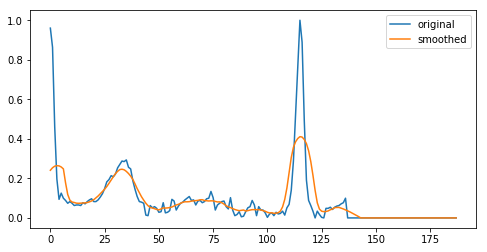

In [35]:
def gaussian_smoothing(data, window, std):
    gauss = gaussian(window ,std, sym=True)
    data = np.convolve(gauss/gauss.sum(), data, mode='same')
    return data

def gauss_wrapper(data):
    return gaussian_smoothing(data, 12, 7)

fig = plt.figure(figsize=(8,4))
plt.plot(train_data.iloc[1,:], label="original")
plt.plot(gauss_wrapper(train_data.iloc[1,:]), label="smoothed")
plt.legend()

In [0]:
def gradient(data, normalize=True):
    data = data.diff(axis=1, periods=3)
    if normalize:
        data = data.apply(lambda x: x/x.abs().max(), axis=1)
    return data

def preprocess(data): 
    data = data.abs().rolling(7, axis=1).max()
    data = data.fillna(method="bfill",axis=1)
    data = decimate(data, axis=1, q=5)
    data[np.abs(data) < .05] = 0
    return pd.DataFrame(data)

x_train_grad = gradient(train_data)
x_test_grad = gradient(test_data)

x_train_preprocessed = preprocess(pd.concat([train_data, x_train_grad, gradient(x_train_grad)], axis=1))
x_test_preprocessed = preprocess(pd.concat([test_data, x_test_grad, gradient(x_test_grad)], axis=1))

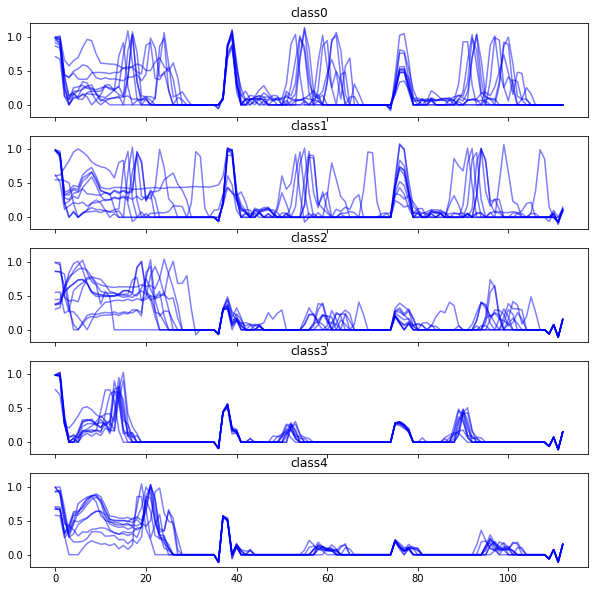

In [37]:

plot(x_train_preprocessed, Y_train)